<a href="https://colab.research.google.com/github/roxyrong/ml-esg-3/blob/main/eng_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

tqdm_notebook.pandas()

In [2]:
data_df = pd.read_parquet("../dataset/train_df.parquet")

In [3]:
data_df = data_df[data_df["language"] == "English"]

In [44]:
data_df.head()

,url,title,content,impact_length_idx,language,sentence,embedding
0,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,ESG-focused financial technology company Arabe...,1.0,English,Arabesque AI Appoints Carolina Minio Paluello ...,"[-0.024175957, -0.034886625, -0.0119500775, 0...."
1,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,The company also announced the appointment of ...,1.0,English,Arabesque AI Appoints Carolina Minio Paluello ...,"[-0.010523278, -0.030339997, 0.009994219, 0.02..."
2,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,Wong said: \n“Personalised portfolios demand ...,1.0,English,Arabesque AI Appoints Carolina Minio Paluello ...,"[-0.016905462, -0.03435323, 0.0052366294, 0.02..."
3,https://www.esgtoday.com/ukraine-war-inflation...,"Ukraine War, Inflation Reduction Act Driving F...",One of the key themes of the report is the imp...,2.0,English,"Ukraine War, Inflation Reduction Act Driving F...","[0.011054499, -0.04202184, -0.0031941922, 0.02..."
4,https://www.esgtoday.com/eu-regulators-welcome...,"EU Regulators Welcome, Critique New European S...",Europe’s three primary financial regulatory ag...,0.0,English,"EU Regulators Welcome, Critique New European S...","[-0.004017994, -0.024552504, -0.034230728, 0.0..."


In [4]:
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

In [5]:
data_df["sentence"] = data_df["title"] + " || " + data_df["content"]
sentences = list(data_df["sentence"])

In [6]:
embeddings = model.encode(sentences)

In [7]:
data_df["embedding"] = list(embeddings)

In [8]:
print(data_df["embedding"].iloc[0].shape)

(768,)


# PCA 

In [10]:
feature_vector = np.stack(data_df["embedding"].to_numpy())

max_components = min(768, len(data_df))

explained_variance = []

for components in range(5, max_components + 1, 5):
    pca = PCA(n_components=components)
    pca.fit(feature_vector)
    total_variance = np.sum(pca.explained_variance_ratio_)
    explained_variance.append(total_variance)


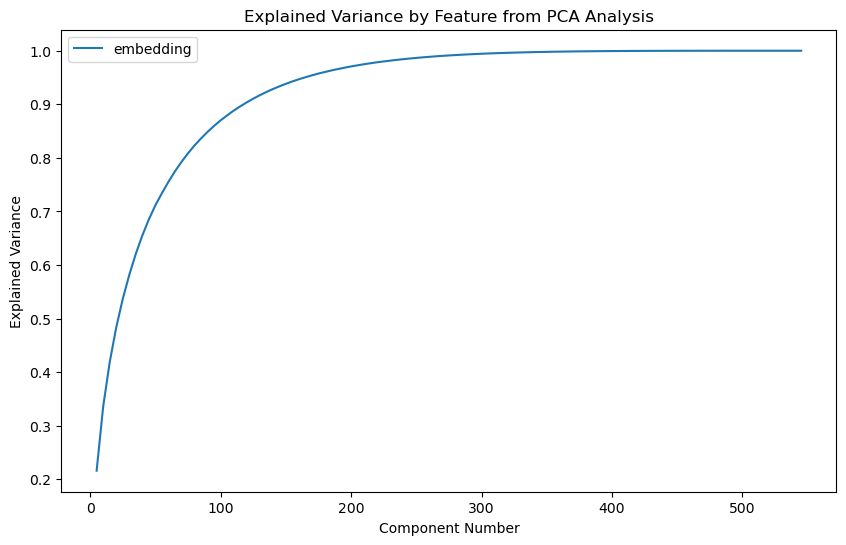

In [11]:
plt.figure(figsize=(10, 6))

plt.plot([i * 5 for i in range(1, len(explained_variance) + 1)],
         explained_variance,
         label="embedding")

plt.title("Explained Variance by Feature from PCA Analysis")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.legend()
plt.show()

# Baseline w/o PCA

In [30]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  
  # pca = PCA(n_components=num_component)
  # pca.fit(X_train)
  # X_train = pca.transform(X_train)
  # print(np.sum(pca.explained_variance_ratio_))
  # X_valid = pca.transform(X_valid)
  
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.5045871559633027
precision: 0.5349006402249491
recall: 0.5045871559633027
f1: 0.5096006196897165


Text(0.5, 1.0, 'Confusion Matrix')

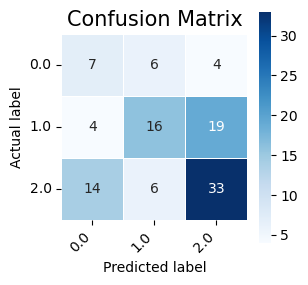

In [31]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)

# Baseline w PCA

In [41]:
num_component = 120


In [42]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  
  pca = PCA(n_components=num_component)
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  print(np.sum(pca.explained_variance_ratio_))
  X_valid = pca.transform(X_valid)
  
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

0.912383
0.9157518
0.91431487
0.91432345
0.9143536
accuracy: 0.4935779816513762
precision: 0.5290005670160471
recall: 0.4935779816513762
f1: 0.5008544733771518


Text(0.5, 1.0, 'Confusion Matrix')

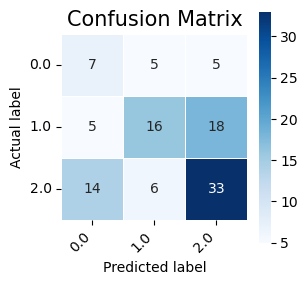

In [43]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)